## Used libiraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# text preprocessing
import string, nltk, re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt_tab')

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Neural Network lib
from tensorflow.keras.layers import Dense, Embedding, Dropout, GlobalAveragePooling1D
import tensorflow.keras as keras
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Data reading

In [6]:
data = pd.read_csv("/content/IMDBDataset.csv", on_bad_lines='skip', engine="python")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
data.describe()

,review,sentiment
count,3980,3980
unique,3978,2
top,Quite what the producers of this appalling ada...,negative
freq,2,2012


In [8]:
data.shape

(3980, 2)

In [9]:
data.isnull().sum().sort_values()

,0
review,0
sentiment,0


In [10]:
data.loc[data['sentiment'] == 'positive', 'sentiment'] = 1
data.loc[data['sentiment'] == 'negative', 'sentiment'] = 0

In [11]:
data.tail()

,review,sentiment
3975,"Visually cluttered, plot less, incredibly mind...",0
3976,"OK,so this film is NOT very well known,and was...",1
3977,"Reeves plays Haji Murad, a hero in 1850's Russ...",0
3978,My brother-in-law and his wife brought the mov...,0
3979,"Now, I'm a big fan of Zombie movies. I admit Z...",0


## Text Analysis and preprocessing

In [12]:
punc = list(string.punctuation)
stop_word = stopwords.words("english")
lemma = WordNetLemmatizer()

In [13]:
def Text_analysis(data):
    data = data.lower()
    data = re.sub('[^a-zA-Z]', ' ', data)
    data = [word for word in word_tokenize(data) if (word not in punc) and (word not in stop_word)]
    data = " ".join(data)

    return data



In [14]:
data['review'] = data['review'].apply(Text_analysis)

In [15]:
data.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,1
1,wonderful little production br br filming tech...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter mattei love time money visually stunnin...,1


In [16]:
X = data['review']
y = data['sentiment']

## OneHot Encoding

In [17]:
label = to_categorical(y, 2)
label[0]

array([0., 1.])

## Tokenization

In [18]:
tokenize = Tokenizer()
tokenize.fit_on_texts(X)

token_sequance = tokenize.texts_to_sequences(X)
max_sentince_size = max([len(i) for i in token_sequance])

pad_data = pad_sequences(token_sequance, maxlen=max_sentince_size, padding='pre')

print('The max sentince size is : ', max_sentince_size)
print('The shape of padding data : ', pad_data.shape)



The max sentince size is :  939
The shape of padding data :  (3980, 939)


In [19]:
voc_size = len(tokenize.word_index) + 1
print('Max vocab size : ', voc_size)

Max vocab size :  34499


In [20]:
X_train, X_test, y_train, y_test = train_test_split(pad_data, label, test_size=0.3, random_state=7)

In [21]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

model = keras.models.Sequential([
    Embedding(voc_size, max_sentince_size, input_length=max_sentince_size),
    GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(2, activation="softmax",  kernel_regularizer=l2(0.001))
])

model.build(input_shape=(None, max_sentince_size))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 939, 939)            │      32,394,561 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 939)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 939)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           1,880 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,396,441 (123.58 MB)

 Trainable params: 32,396,441 (123.58 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)


In [23]:
history = model.fit(X_train, y_train, callbacks=[early_stop], epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.4878 - loss: 0.7424 - val_accuracy: 0.4925 - val_loss: 0.7331
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5074 - loss: 0.7153 - val_accuracy: 0.5050 - val_loss: 0.6905
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5308 - loss: 0.7006 - val_accuracy: 0.5075 - val_loss: 0.6884
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5287 - loss: 0.7021 - val_accuracy: 0.5201 - val_loss: 0.6860
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5445 - loss: 0.7005 - val_accuracy: 0.4992 - val_loss: 0.6935
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5476 - loss: 0.6905 - val_accuracy: 0.5075 - val_loss: 0.7054


In [24]:
history1 = model.fit(X_train, y_train, callbacks=[early_stop], epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5666 - loss: 0.6788 - val_accuracy: 0.5075 - val_loss: 0.7161
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5510 - loss: 0.6905 - val_accuracy: 0.6960 - val_loss: 0.6686
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5836 - loss: 0.6808 - val_accuracy: 0.5075 - val_loss: 0.7444
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5644 - loss: 0.6931 - val_accuracy: 0.6658 - val_loss: 0.6590
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5522 - loss: 0.6958 - val_accuracy: 0.5117 - val_loss: 0.6811
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6174 - loss: 0.6585 - val_accuracy: 0.5168 - val_loss: 0.6796


In [25]:
history2 = model.fit(X_train, y_train, callbacks=[early_stop], epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6313 - loss: 0.6445 - val_accuracy: 0.5109 - val_loss: 0.7115
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6501 - loss: 0.6395 - val_accuracy: 0.5754 - val_loss: 0.6434
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6227 - loss: 0.6728 - val_accuracy: 0.5410 - val_loss: 0.6596
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6381 - loss: 0.6393 - val_accuracy: 0.5101 - val_loss: 0.7270


In [26]:
history3 = model.fit(X_train, y_train, callbacks=[early_stop], epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6534 - loss: 0.6316 - val_accuracy: 0.7236 - val_loss: 0.6014
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6344 - loss: 0.6499 - val_accuracy: 0.6114 - val_loss: 0.6058
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6713 - loss: 0.5978 - val_accuracy: 0.7471 - val_loss: 0.5801
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7220 - loss: 0.5611 - val_accuracy: 0.8275 - val_loss: 0.5633
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7251 - loss: 0.5514 - val_accuracy: 0.5645 - val_loss: 0.6251
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7158 - loss: 0.5622 - val_accuracy: 0.8233 - val_loss: 0.5409
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7641 - loss: 0.5150 - val_accuracy: 0.5955 - val_loss: 0.5927
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7036 - loss: 0.5626 - val_accuracy: 0.5628 - v

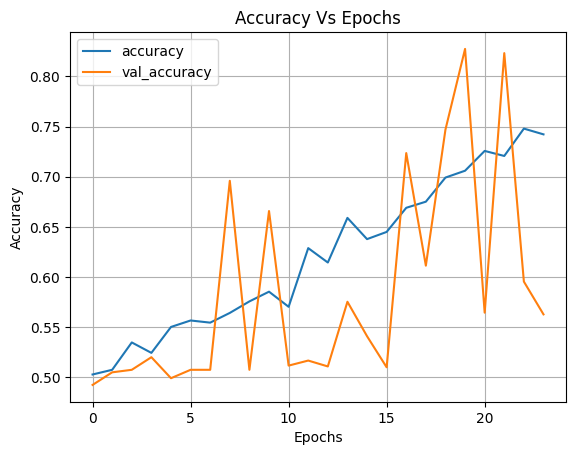

In [27]:
plt.plot(history.history["accuracy"] + history1.history["accuracy"] + history2.history["accuracy"]+history3.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"]+ history1.history["val_accuracy"] + history2.history["val_accuracy"]+history3.history["val_accuracy"], label="val_accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Accuracy Vs Epochs")

plt.legend()
plt.grid()

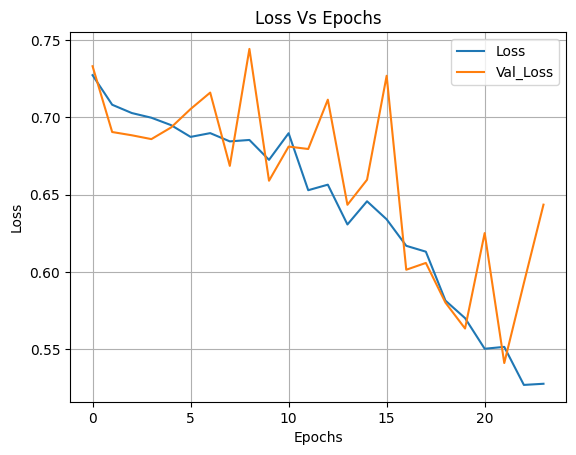

In [28]:
plt.plot(history.history["loss"]+history1.history["loss"]+history2.history["loss"]+history3.history["loss"], label="Loss")
plt.plot(history.history["val_loss"]+history1.history["val_loss"]+history2.history["val_loss"]+history3.history["val_loss"], label="Val_Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("Loss Vs Epochs")

plt.legend()
plt.grid()